# NP, NPC and the Cook Levin Theorem

In [59]:
%%html
<style>
.rise-enabled .cell .input_prompt {
    display: none;
}
</style>

Dependencies for this notebook: `graphviz` executable installed on the system and on the path, [networkx](https://anaconda.org/anaconda/networkx)   and [graphviz python](https://anaconda.org/conda-forge/python-graphviz) anaconda packages. (See [here](https://graphviz.readthedocs.io/en/stable/index.html) for the documentation of the latter package.)

Please run the utility code at the bottom of this notebook first.

You should be able to upload this notebook to the JupyterHub instance on canvas.

__comment:__ In this notebook I use `x_17` and not `x17` for 3SAT and 3NAND formula to be more consistent with our notation for NAND. This is of course not very important.

### Utility code (skip reading but run this first)

In [ ]:
#%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [ ]:
import graphviz
from graphviz import Graph
from graphviz import Digraph

In [ ]:
import networkx as nx

import pydotplus

import pygraphviz as pgv

def nxgraph(G):
    #P = pydotplus.graph_from_dot_data(G.source)
    #return nx.drawing.nx_pydot.from_pydot(P)
    P= pgv.AGraph(G.source)
    return nx.Graph(P)


In [ ]:
def subscriptdigit(d):
    return ["₀","₁","₂","₃","₄","₅","₆","₇","₈","₉"][d]

def subscript(s):
    digits = ["0","1","2","3","4","5","6","7","8","9"]
    return "".join([subscriptdigit(int(s[i])) if s[i] in digits else s[i] for i in range(len(s))])

In [ ]:
def scale(G,sizeparam="10,5"):
    G.graph_attr.update(size=sizeparam, ratio="fill")
    return G

In [ ]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
COUNTER=0

class Bit:
    """A class representing a logical bit. 
       Keeps track of operations that are done to it"""
 
    def __init__(self, program):
        self.program = program if isinstance(program,tuple) else (program,)
        global COUNTER
        COUNTER += 1
  
    def op(self,oper, other = None):
        if other is None:
            return Bit((oper,self.program))
        return Bit((oper,self.program,other.program))
        
    def __and__(self,other): return self.op("∧", other)
    def __or__(self,other): return self.op("∨", other)
    def __invert__(self): return self.op("¬")
    
    def __repr__(self): return f"Bit({self.program})" 


In [ ]:
def AND(a,b): 
    if isinstance(a,int) and isinstance(b,int):
        return int(bool(a) and bool(b))
    if isinstance(a,bool) and isinstance(b,bool):
        return a and b
    return a & b

def OR(a,b): 
    if isinstance(a,int) and isinstance(b,int):
        return int(bool(a) or bool(b))
    if isinstance(a,bool) or isinstance(b,bool):
        return a and b
    return a | b

def NOT(a): 
    if isinstance(a,Bit): return ~a
    if isinstance(a,int): return int(not a)
    return not a

def NAND(a,b):
    if isinstance(a,Bit) and isinstance(b,Bit):
        return a.op("N",b)
    return NOT(AND(a,b))

In [ ]:
a = Bit("a")
b = Bit("b")
c = a & b
print(a)
print(b)
print(c)

In [ ]:
def bits(n):
    return [Bit(f"X[{i}]") for i in range(n)]

In [ ]:
def p2f(P):
  """Recursive function to transform a program of a Bit into a formula"""
  if len(P)==1:
    return P[0]
  if len(P)==2:
    return P[0] + p2f(P[1])
  if len(P)==3:
    return f"({p2f(P[1])} {P[0]} {p2f(P[2])})"
  return f"{P[0]}("+",".join([p2f(P[i]) for i in range(1,len(P))])+")"



In [ ]:
counter = 0
def AON_(P):
    """Recursive function to transform a program of a bit into an AON straightline program"""
    def uid():
        global counter
        counter +=1
        return f"z_{counter}"
    funcs = {"∧": "AND", "∨": "OR", "¬": "NOT", "N":"NAND" }
    if len(P)==1:
        return "",P[0]
    op = funcs[P[0]]  
    if len(P)==2:
        prog, out_ = AON_(P[1])
        out = uid() 
        return prog+f"{out} = {op}({out_})\n", out
    if len(P)==3:
        prog1,out1 = AON_(P[1])
        prog2,out2 = AON_(P[2])
        out = uid()
        return prog1+prog2+f"{out} = {op}({out1},{out2})\n", out

In [ ]:
def AON(f, n=None):
    """Take either a function or a bit and return the AON program"""
    global counter
    counter = 0
    if isinstance(f,Bit):
        P = f.program
    else:
        if n is None:
            n = len(signature(f).parameters)
        P = f(*bits(n)).program
    prog, out = AON_(P)
    return prog.replace(out,"Y[0]")

In [ ]:
def formula(f):
    """Take either a function or a bit and return the AON program"""
    if isinstance(f,Bit):
        return Math(p2f(f.program))
    n = len(signature(f).parameters)
    F = p2f(f(*bits(n)).program)
    return Math(F)

In [ ]:
def circuit_(P, d : schemdraw.Drawing , dx=0, dy=0, drawn = {}):
  """Recursive function to draw a circuit. Gets the Bit bit and outputs the circuit used to compute it"""
  if P in drawn:
    return drawn[P]
  maxx = dx
  maxy = dy
  outs = []
  gates = { "∧" : logic.And, "∨" : logic.Or, "¬": logic.Not, "N": logic.Nand } 
  for c in P[1:]:
    dx_ , dy_ , out = circuit_(c,d,dx,dy ,drawn)
    outs.append(out)
    maxx = max(dx_,maxx)
    maxy = max(dy_,maxy)
    dy = dy_ + 1
  maxx += 2
  x,y = maxx,maxy
  gate = gates[P[0]] if P[0] in gates else logic.Dot
  g = gate(at = (x,y))
  if isinstance(g, logic.Dot):
    g.label(f"{P[0]}")
  d += g
  for i,out in enumerate(outs):
    loc = getattr(g,f"in{i+1}") 
    d += logic.Wire().at(out).to(loc)  
  drawn[P] =  x,y, g.out if hasattr(g,"out") else (x,y)
  return drawn[P]

def draw_circ(*Ys):
  drawn = {}
  dx,dy = 0,0
  with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    for i,y in enumerate(Ys):
      label= f"$Y[{i}]$"
      x,dy_, out = circuit_(y.program,d,dx,dy, drawn)
      d += logic.Dot().at(out).label(label)
      dy = dy_+2


In [ ]:
import re
def parse(P):
    """Take an AON program and split each line into components"""
    result  = []
    for line in P.split('\n'):
        split = re.split("=|\(|\)|,| ",line) 
        split = [x for x in split if x != ""]
        if split:
            result.append(split)
    return result
 

In [ ]:
def circuit(f,n=None):
    """Take a function or a bit and output circuit"""
    if isinstance(f,Bit):
        res = f
    elif isinstance(f,str):
        f= FUNC(f)
    if callable(f):
        if n is None:
            n = len(signature(f).parameters)
        res = f(*bits(n))
    return draw_circ(*res) if isinstance(res,(tuple,list)) else draw_circ(res)

In [ ]:
def circ_size(f,n=None):
    if n is None:
        n = len(signature(f).parameters)
    global COUNTER
    COUNTER = 0
    res = f(*bits(n))
    return COUNTER-n    
    

In [ ]:
def evalp(tuples,x, debug=True):
    """Evaluate a parsed program on an input"""
    variables = { f"X[{i}]":x[i] for i in range(len(x)) }
    for rhs,op,*oper in tuples:
        if debug: print(f"Evaluating {rhs} = {op}({','.join(oper)}):\t variables = {variables}")
        oper = [variables[o] for o in oper]
        variables[rhs] = globals()[op](*oper)
    return variables["Y[0]"]

In [ ]:
def EVAL(P,x, debug=True): 
    """Evaluate an AON-CIRC program on an input x"""
    return evalp(parse(P),x, debug)

In [ ]:
def nparams(P): 
    """Returns number of parameters of an AON-CIRC program P"""
    for i in range(len(P)+1):
        if f'X[{i}]' not in P: return i
def FUNC(P):
    """Returns the function that AON-CIRC program P computes"""
    # hack to get signature for small # of params
    n = nparams(P)
    if n == 1:
        def prog(a): return EVAL(P,[a],debug=False)
    elif n ==2:
        def prog(a,b): return EVAL(P,[a,b],debug=False)
    elif n ==3:
        def prog(a,b,c): return EVAL(P,[a,b,c],debug=False)
    elif n ==4:
        def prog(a,b,c,d): return EVAL(P,[a,b,c,d],debug=False)
    elif n==5:
        def prog(a,b,c,d,e): return EVAL(P,[a,b,c,d,e],debug=False)
    else:
        def prog(*x): return EVAL(P,x,debug=False)
    return prog

In [ ]:
import itertools
from IPython.display import Markdown, display, Math
from inspect import signature

def table(f,n=None):
  """Generate truth table of a function"""
  if n is None:
    n = len(signature(f).parameters)
  m = max(n+2,len(f.__name__)+4)
  res = "x".ljust(m) + " | " + f"{f.__name__}(x)".ljust(m) 
  res += "\n" + "-"*m+"-|-"+ "-"*m 
  
  for x in itertools.product([0,1],repeat=n):
    s = "".join([str(c) for c in x])
    #y = f(*[bool(i) for i in x])
    y = f(*x)
    #if isinstance(y,(list,tuple)):
    #    y = [int(bool(i)) for i in y]
    #else:
    #    y = int(bool(y))
        
    res += "\n"+ s.ljust(m) + " | " + str(y).ljust(m)
  res +="\n"
  return Markdown(res)

In [ ]:
import re
from collections import defaultdict
def numinout(prog):
    '''Compute the number of inputs and outputs of a NAND program, given as a string of source code.'''
    n = max([int(s[2:-1]) for s in re.findall(r'X\[\d+\]',prog)])+1
    m = max([int(s[2:-1]) for s in re.findall(r'Y\[\d+\]',prog)])+1
    return n,m

In [ ]:
def parseline(line, numargs = 0):
    """Parse a line of the form foo = 'OP( bar1, bar2, bar3)'
       to ['foo','OP','bar1','bar2','bar2'].
       If numargs > number of arguments in line then add empty strings to the list as needed."""
    i = line.find("=")
    j = line.find("(")
    k = line.find(")")
    if i<0 or j<0 or k<0: raise Exception(f"Line not formatted properly: {line}")
    args = [a.strip() for a in line[j+1:k].split(",")]
    if len(args)<numargs: args += [""]*(numargs-len(args))
    return [line[:i].strip() , line[i+1:j].strip()] + args
        

## NANDSAT

__Input:__ $Q \in \{0,1\}^*$: NAND-CIRC program of $n$ inputs and $1$ output

__Output:__ $1$ iff $\exists y\in \{0,1\}^n$ s.t. $Q(y)=1$.

In [60]:
xor5 = r'''
u   =  NAND(X[0],X[1])
v   = NAND( X[0] , u)
w   = NAND( X[1] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[2])
v   = NAND( s   , u)
w   = NAND( X[2] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[3])
v   = NAND( s   , u)
w   = NAND( X[3] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[4])
v   = NAND( s   , u)
w   = NAND( X[4] , u)
Y[0] = NAND( v   , w)
'''[1:]

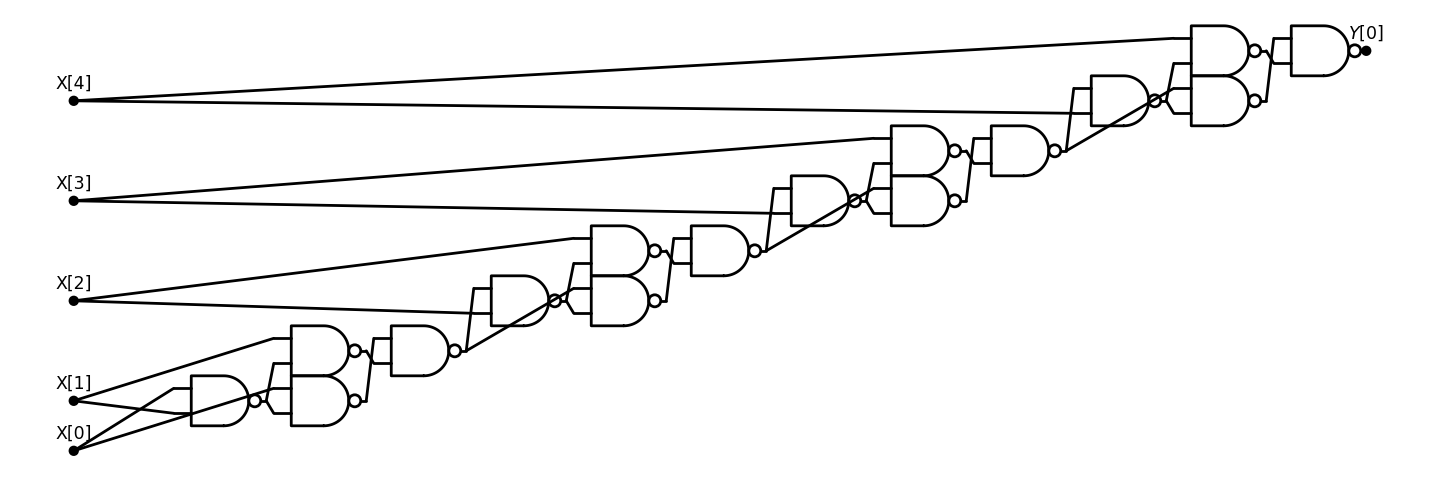

In [61]:
circuit(xor5)

In [62]:
CONSTPREFIX = r'''
temp = NAND(X[0],X[0])
one = NAND(X[0],temp)
zero = NAND(one,one)
'''[1:]

In [63]:
# "hardwire" an input x to a NAND program Q
# return Q' s.t. Q'(y)=Q(xy)
def hardwire(Q,x):
    n = len(x)
    for i in range(n): 
        Q = Q.replace(f'X[{i}]',('one' if x[i] else 'zero'))
    for i in range(n,2*len(Q)): 
        Q = Q.replace(f'X[{i}]',f'X[{i-n}]')
    return CONSTPREFIX+Q

In [ ]:
def indexat(t): return t

def unroll__(P,n,m,T):
    result = CONSTPREFIX
    for t in range(T // P.count('\n')):
        i = indexat(t) # value of i in T-th iteration
        valid = ('one' if i < n else 'zero' )
        inp   = ('X[i]' if i < n else 'zero')
        out   = ('Y[i]' if i < m else 'nonsense')
        result += P.replace('Xvalid[i]',valid).replace('X[i]',inp
                           ).replace('Y[i]',out).replace('[i]',f'[{i}]')
    return result

In [64]:
Q = hardwire(xor5,[1,1,1])
print(Q)

temp = NAND(X[0],X[0])
one = NAND(X[0],temp)
zero = NAND(one,one)
u   =  NAND(one,one)
v   = NAND( one , u)
w   = NAND( one , u)
s   = NAND( v   , w)
u   = NAND( s   , one)
v   = NAND( s   , u)
w   = NAND( one , u)
s   = NAND( v   , w)
u   = NAND( s   , X[0])
v   = NAND( s   , u)
w   = NAND( X[0] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[1])
v   = NAND( s   , u)
w   = NAND( X[1] , u)
Y[0] = NAND( v   , w)



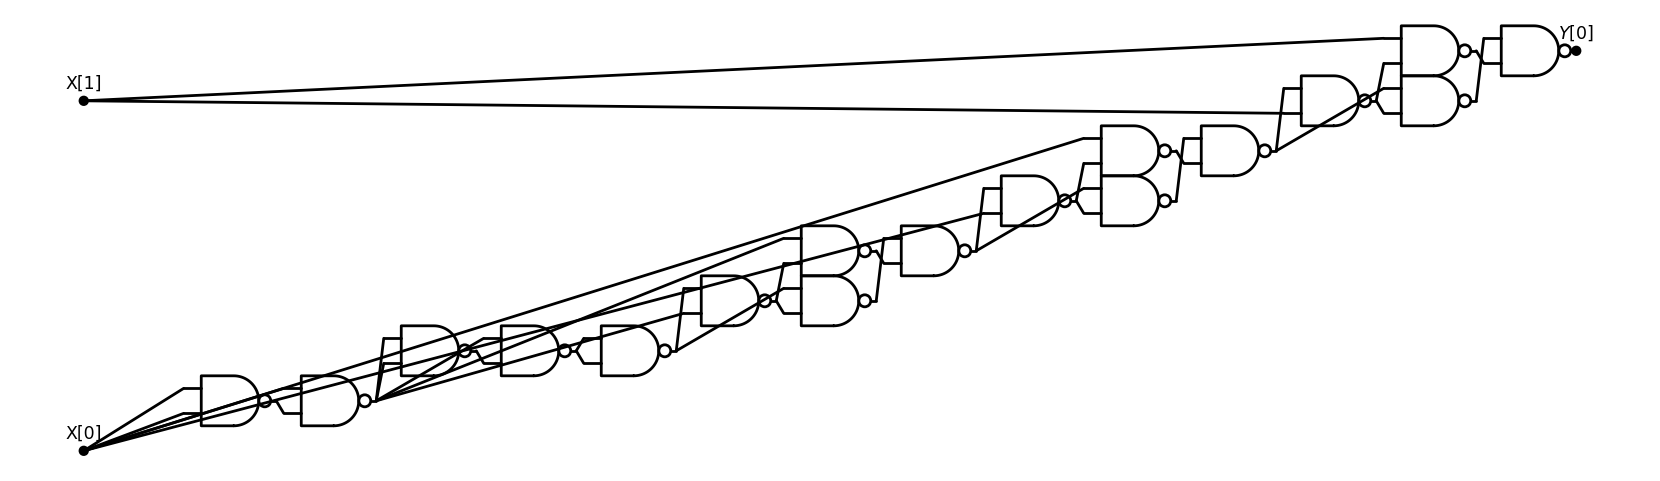

In [65]:
C = circuit(Q)
C

In [67]:
FUNC(Q)(1,0)

0

## 3NAND

__Input:__ $\psi \in \{0,1\}^*$ representing 3NAND formula of form $(x_i = x_j NAND x_k) \wedge \cdots$

__Output:__ $1$ iff $\exists x\in \{0,1\}^*$ s.t. $\psi(x)=1$. 

In [68]:
Ψ = "(z0 = NAND(z2,z3) ) ∧ (z3 = NAND(z2,z1) ) ∧ (z1 = NAND(z2,z3) ) "

In [ ]:
# Evaluate 3CNAND Ψ on assignment x 
# Both are represented as strings
def eval3NAND(Ψ,x):

    def varval(v):
        return  int(x[int(v[1:])]) # assume vars are x_###
    
    for (v0,v1,v2) in getnandclauses(Ψ):
        if  varval(v0) != 1-varval(v1)*varval(v2): return False
    
    return True


In [ ]:

# Clause list of a 3CNF/3NAND formula  φ
def getcnfclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        (v0,_,v1,_,v2) = c.strip()[1:-1].split()
        res.append((v0.strip(),v1.strip(),v2.strip()))
    return res

def getnandclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        foo,bar,blah, = filter(None,re.split('\s*=\s*NAND\s*\(\s*|\s*\,\s*|\s*\)\s*|\s+',c.strip()[1:-1]))
        res.append((foo.strip(),bar.strip(),blah.strip()))
    return res



# number of variables of a formula φ
def numvars(φ):
    for n in range(len(φ)-1,0,-1):
        if φ.find(f'x{n}')>= 0 or φ.find(f'z{n}')>= 0: return n+1
    raise Exception


In [ ]:
getnandclauses(Ψ)

__Thm:__ $NANDSAT \leq_p 3NAND$

In [ ]:
# Reduce NANDSAT to 3NAND
# Input: NAND prog Q
# Output: 3NAND formula Ψ
#        s.t. Ψ satisfiable iff Q is
def NANDSAT23NAND_(Q):
    # if Q doesn't start with CONSTPREFIX: Q = CONSTPREFIX + Q
    if Q[:len(CONSTPREFIX)] != CONSTPREFIX:
        Q = CONSTPREFIX + Q
    n, _  = numinout(Q)
    Ψ = ''

    #varidx[u] is n+line where u is last written to
    varidx = defaultdict(lambda : n+ 2) # line 2 corresponds to zero
    
    for i in range(n): varidx[f'X[{i}]'] = i # setup x_0...x_n-1
    
    j = n
    for line in Q.split('\n'):
        if not line.strip(): continue
        foo,_,bar,blah = parseline(line) # split "foo = NAND(bar,blah)"
        Ψ +=  f"(z{j} = NAND(z{varidx[bar]},z{varidx[blah]}) ) ∧ "
        varidx[foo] = j
        j += 1
    Ψ += f"(z{varidx['Y[0]']} = NAND(z{varidx['zero']},z{varidx['zero']}) )"
    return Ψ

In [ ]:
# Version of input above that keeps track of satisfying assignment y if given
#
# Reduce NANDSAT to 3NAND
# Input: NAND prog Q
# Output: 3NAND formula Ψ
#        s.t. Ψ satisfiable iff Q is
def NANDSAT23NAND(Q,y=[]):
    if Q[:len(CONSTPREFIX)] != CONSTPREFIX:
        Q = CONSTPREFIX + Q
    n, _  = numinout(Q)
    Ψ = ''
    z = defaultdict(int)

    #varidx[u] is n+line where u is last written to
    varidx = defaultdict(lambda : n+ 2) # line 2 corresponds to zero

    for i in range(n): 
        varidx[f'X[{i}]'] = i # setup x_0...x_n-1
        if y: z[i] = y[i]
    
    j = n
    for line in Q.split('\n'):
        if not line.strip(): continue
        foo,_,bar,blah = parseline(line)
        Ψ +=  f"(z{j} = NAND(z{varidx[bar]},z{varidx[blah]}) ) ∧ "
        if y: z[j] = NAND(z[varidx[bar]],z[varidx[blah]])
        varidx[foo] = j
        j += 1
    Ψ += f"(z{varidx['Y[0]']} = NAND(z{varidx['zero']},z{varidx['zero']}) )"
    return Ψ if not y else (Ψ,[z[i] for i in range(j)])

In [69]:
print(xor5) 
lines = xor5.count('\n')
n = max([i for i in range(2*lines) if xor5.find(f"X[{i}]")>=0])+1
print(f"Number of lines: {lines}, Number of variables: {n}")

u   =  NAND(X[0],X[1])
v   = NAND( X[0] , u)
w   = NAND( X[1] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[2])
v   = NAND( s   , u)
w   = NAND( X[2] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[3])
v   = NAND( s   , u)
w   = NAND( X[3] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[4])
v   = NAND( s   , u)
w   = NAND( X[4] , u)
Y[0] = NAND( v   , w)

Number of lines: 16, Number of variables: 5


In [70]:
Ψ = NANDSAT23NAND_(xor5)
print(Ψ)
print(f"Vars: {numvars(Ψ)}, Clauses: {len(getnandclauses(Ψ))}")

(z5 = NAND(z0,z0) ) ∧ (z6 = NAND(z0,z5) ) ∧ (z7 = NAND(z6,z6) ) ∧ (z8 = NAND(z0,z1) ) ∧ (z9 = NAND(z0,z8) ) ∧ (z10 = NAND(z1,z8) ) ∧ (z11 = NAND(z9,z10) ) ∧ (z12 = NAND(z11,z2) ) ∧ (z13 = NAND(z11,z12) ) ∧ (z14 = NAND(z2,z12) ) ∧ (z15 = NAND(z13,z14) ) ∧ (z16 = NAND(z15,z3) ) ∧ (z17 = NAND(z15,z16) ) ∧ (z18 = NAND(z3,z16) ) ∧ (z19 = NAND(z17,z18) ) ∧ (z20 = NAND(z19,z4) ) ∧ (z21 = NAND(z19,z20) ) ∧ (z22 = NAND(z4,z20) ) ∧ (z23 = NAND(z21,z22) ) ∧ (z23 = NAND(z7,z7) )
Vars: 24, Clauses: 20


In [71]:
z = NANDSAT23NAND(xor5,[1,0,0,1,1])[1]
z, len(z)

([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], 24)

In [72]:
eval3NAND(Ψ,z)

True

In [ ]:
z_ = list(z)
z_[2] = 1-z[2]
eval3NAND(Ψ,z_)

In [ ]:
Q = hardwire(xor5,[1,1])
(Ψ,y) = NANDSAT23NAND(Q,[1,1,1])
eval3NAND(Ψ,y)

## 3SAT 

__Input:__ 3CNF formula:  AND of $m$ _clauses_.   Clause = OR of three _literals_. Literal = variable or its negation.

__Goal:__ Output 1 iif formula _satisfiable_.

In [73]:
φ = "(x0 ∨ ¬x3 ∨ x2 ) ∧ (¬x0 ∨ x1 ∨ ¬x2 ) ∧ (x1 ∨ x2 ∨ ¬x3 )  "

In [ ]:
# Evaluate 3CNF φ on assignment x 
# Both are represented as strings
def evalcnf(φ,x):

    def varval(v):
        return (1-x[int(v[2:])])  if v[0]=="¬" else x[int(v[1:])]
    
    for (v0,v1,v2) in getcnfclauses(φ):
        # print(c+str([varval(v0),varval(v1),varval(v2)]))
        if not varval(v0)+varval(v1)+varval(v2): return False
    
    return True

# Clause list of a 3CNF φ
def getcnfclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        (v0,_,v1,_,v2) = c.strip()[1:-1].split()
        res.append((v0.strip(),v1.strip(),v2.strip()))
    return res

In [ ]:
numvars(φ)

__Thm:__ $3NAND \leq_p 3SAT$

__Proof:__ $a = NAND(b,c)$   iff  $(\neg a \vee \neg b \vee \neg c) \wedge (a \vee b) \wedge (a \vee c)$

In [74]:
# Reduce 3NAND to 3SAT
# Input: 3NAND formula Ψ
# Output: 3CNF formula φ
#        s.t.  φ satisfiable iff Ψ is
def NAND23SAT_(Ψ):
    φ = ""
    for (a,b,c) in getnandclauses(Ψ):
        φ += f'(¬{a} ∨ ¬{b} ∨ ¬{c}) ∧ ({a} ∨ {b}  ∨ {b}) ∧ ({a}  ∨  {c} ∨ {c}) ∧ '
    return φ[:-3] # chop off redundant ∧

In [75]:
Ψ = "(x0 = NAND(x2,x3) ) ∧ (x3 = NAND(x2,x1) ) ∧ (x1 = NAND(x2,x3) ) "
NAND23SAT_(Ψ)

'(¬x0 ∨ ¬x2 ∨ ¬x3) ∧ (x0 ∨ x2  ∨ x2) ∧ (x0  ∨  x3 ∨ x3) ∧ (¬x3 ∨ ¬x2 ∨ ¬x1) ∧ (x3 ∨ x2  ∨ x2) ∧ (x3  ∨  x1 ∨ x1) ∧ (¬x1 ∨ ¬x2 ∨ ¬x3) ∧ (x1 ∨ x2  ∨ x2) ∧ (x1  ∨  x3 ∨ x3)'

In [ ]:
# Same as above but keeping track of assignment
def NAND23SAT(Ψ,y=[]):
    φ = ""
    def makex(a): return "x"+a[1:]
    for (a,b,c) in getnandclauses(Ψ):
        a = makex(a)
        b = makex(b)
        c = makex(c)
        φ += f'(¬{a} ∨ ¬{b} ∨ ¬{c}) ∧ ({a} ∨ {b}  ∨ {b}) ∧ ({a}  ∨  {c} ∨ {c}) ∧ '
    return (φ[:-3],y) if y else φ[:-3] # chop off redundant ∧

In [76]:
φ = NAND23SAT(NANDSAT23NAND(Q))
print(φ)

(¬x2 ∨ ¬x0 ∨ ¬x0) ∧ (x2 ∨ x0  ∨ x0) ∧ (x2  ∨  x0 ∨ x0) ∧ (¬x3 ∨ ¬x0 ∨ ¬x2) ∧ (x3 ∨ x0  ∨ x0) ∧ (x3  ∨  x2 ∨ x2) ∧ (¬x4 ∨ ¬x3 ∨ ¬x3) ∧ (x4 ∨ x3  ∨ x3) ∧ (x4  ∨  x3 ∨ x3) ∧ (¬x5 ∨ ¬x3 ∨ ¬x3) ∧ (x5 ∨ x3  ∨ x3) ∧ (x5  ∨  x3 ∨ x3) ∧ (¬x6 ∨ ¬x3 ∨ ¬x5) ∧ (x6 ∨ x3  ∨ x3) ∧ (x6  ∨  x5 ∨ x5) ∧ (¬x7 ∨ ¬x3 ∨ ¬x5) ∧ (x7 ∨ x3  ∨ x3) ∧ (x7  ∨  x5 ∨ x5) ∧ (¬x8 ∨ ¬x6 ∨ ¬x7) ∧ (x8 ∨ x6  ∨ x6) ∧ (x8  ∨  x7 ∨ x7) ∧ (¬x9 ∨ ¬x8 ∨ ¬x3) ∧ (x9 ∨ x8  ∨ x8) ∧ (x9  ∨  x3 ∨ x3) ∧ (¬x10 ∨ ¬x8 ∨ ¬x9) ∧ (x10 ∨ x8  ∨ x8) ∧ (x10  ∨  x9 ∨ x9) ∧ (¬x11 ∨ ¬x3 ∨ ¬x9) ∧ (x11 ∨ x3  ∨ x3) ∧ (x11  ∨  x9 ∨ x9) ∧ (¬x12 ∨ ¬x10 ∨ ¬x11) ∧ (x12 ∨ x10  ∨ x10) ∧ (x12  ∨  x11 ∨ x11) ∧ (¬x13 ∨ ¬x12 ∨ ¬x0) ∧ (x13 ∨ x12  ∨ x12) ∧ (x13  ∨  x0 ∨ x0) ∧ (¬x14 ∨ ¬x12 ∨ ¬x13) ∧ (x14 ∨ x12  ∨ x12) ∧ (x14  ∨  x13 ∨ x13) ∧ (¬x15 ∨ ¬x0 ∨ ¬x13) ∧ (x15 ∨ x0  ∨ x0) ∧ (x15  ∨  x13 ∨ x13) ∧ (¬x16 ∨ ¬x14 ∨ ¬x15) ∧ (x16 ∨ x14  ∨ x14) ∧ (x16  ∨  x15 ∨ x15) ∧ (¬x17 ∨ ¬x16 ∨ ¬x1) ∧ (x17 ∨ x16  ∨ x16) ∧ (x17  ∨  x1 ∨ x1) ∧ (¬x18 ∨ ¬x16 ∨ ¬x17) ∧ (x18 ∨ x16  ∨ 

In [ ]:
# Reduction φ ↦ G
def SAT2IS_(φ):
    n = numvars(φ) 
    G =Graph(engine='neato')
    
    # add pairs "x_i=0" and "x_i=1"
    for i in range(n): G.edge(f'x_{i}=0',f'x_{i}=1')
        
    # map "x_7" with index 5 to "5)x_7≠0", "¬x_12" with index 6 to "6)x_12≠1"
    def nodename(v,c): return str(c)+')'+(v[1:]+"≠1" if v[0]=="¬" else v+"≠0")
    
    #map "5)x_7≠0" to its neighbor "x_7=0"
    def neighbor(n):   return n.split(')')[1].split('≠')[0]+"="+n[-1]
    
    c = 0
    for C in getcnfclauses(φ):
        (u,v,w) = (nodename(C[0],c),nodename(C[1],c+1),nodename(C[2],c+2))
        
        # add triangle of clause
        G.edges([(u,v),(v,w),(u,w)])
        
        # connect each vertex to inconsistent neighbor
        G.edges([(u,neighbor(u)),(v,neighbor(v)),(w,neighbor(w))])
        c += 3
    
    return G

In [ ]:
# same reduction but taking care of colors and keeping track what happens to an assignment
def SAT2IS(φ,x=""):
    S = []
#    G.node(u,style='filled',fillcolor=('red' if x and x[i]=="0" else 'green'))
        
    n = numvars(φ) 
    G =Graph() # (engine='neato')
    
    def nname(c,v): return f"({c},{v})"
    
    c = 0
    nodes = {}
    for i in range(n):
        nodes["x"+str(i)] = []
        nodes["¬x"+str(i)] = []
    
    for C in getcnfclauses(φ):
        sat = False
        for u in C: 
            if x and (not sat) and (((u[0]=="¬") and (x[int(u[2:])]=="0")) or ((u[0]!="¬") and (x[int(u[1:])]=="1"))):
                G.node(nname(c,u),f"{c},{subscript(u)}",fontsize="10",style='filled',fillcolor='green')
                S.append(nname(c,u))
                sat = True
            else:
                G.node(nname(c,u),f"{c},{subscript(u)}",fontsize="10")
            negu = u[1:] if u[0]=="¬" else "¬"+u
            for v in nodes[negu]: G.edge(nname(c,u),v,color="red") 
            nodes[u].append(nname(c,u))
        G.edges([[nname(c,C[0]), nname(c,C[1])],[nname(c,C[1]), nname(c,C[2])],[nname(c,C[0]), nname(c,C[2])]])
        c += 1
    
    return (scale(G) if not x else (scale(G),S))

In [ ]:
# same reduction as above but handling colors and showing the resulting cut when the original graph has independent set
def IS2MAXCUT(G,I=[]):
    G =nxgraph(G)
    S = []
    H =Graph() # engine='sfdp')
    H.node("source",style='filled',fillcolor='blue')
    S.append("source")
    for v in G.nodes():
        color = ('red' if I and v in I else 'lightblue')
        H.node(v,label=subscript(v),fontsize="10",style='filled',fillcolor=color, shape="square")
        ecol = 'black'
        pwidth = '1'
        if I and v in I: 
            S.append(v)
            ecol = 'red'
            pwidth = '2'
        H.edge("source",v,color=ecol,penwidth=pwidth)  # len="2"
    
    j =0
    for (u,v) in G.edges():
        g1 = "e"+str(j)+"a"
        g2 = "e"+str(j)+"b"
        c1 = 'green'
        c2 = 'green'
        if I and (not u in I):
            c1 = 'red'
            S.append(g1)
        if I and (not v in I):
            c2 = 'red'
            S.append(g2)
        gadget = Graph("gadget"+str(j))
        gadget.node(g1,subscript("e0"),fontsize="10",style='filled',fillcolor=c1)
        gadget.node(g2,subscript("e1"),fontsize="10",style='filled',fillcolor=c2)
        gadget.edge(g1,g2,color=('red' if (g1 in S) != (g2 in I) else 'black'), penwidth=('2' if (g1 in S) != (g2 in I) else '1')) # len="1"
        gadget.edge(u,g1, color=('red' if (g1 in S) != (u in I) else 'black'),penwidth =('2' if (g1 in S) != (u in S) else '1')  ) # len="1"
        gadget.edge(v,g2, color=('red' if (g2 in S) != (v in I) else 'black'),penwidth= ('2' if (g2 in S) != (v in S) else '1') ) # len="1"
        
        H.subgraph(gadget)
        H.edge(g1,"source",color=('red' if (g1 in S)  else 'black'),penwidth=('2' if (g1 in S)  else '1')) # len="2.5"
        H.edge(g2,"source",color=('red' if (g2 in S)  else 'black'),penwidth= ('2' if (g2 in S)  else '1') )
        j +=1
        
    
    return (scale(H),S) if I else scale(H)

## Putting everything together

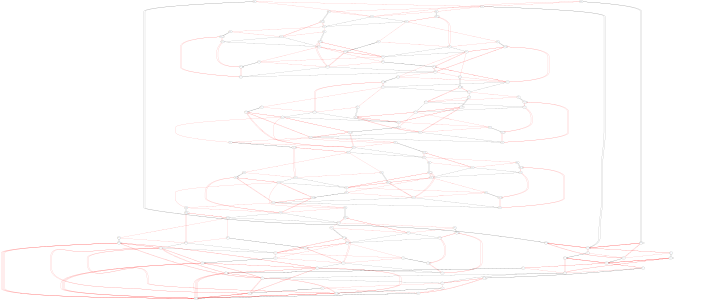

In [77]:
SAT2IS(*NAND23SAT(*NANDSAT23NAND(xor5,(1,0,1,0,1))))[0]

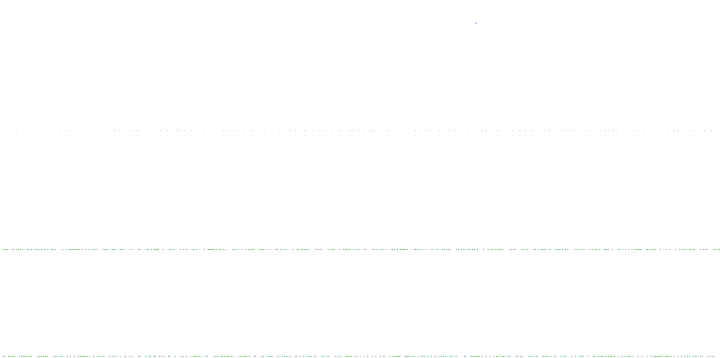

In [78]:
IS2MAXCUT(SAT2IS(NAND23SAT(NANDSAT23NAND(xor5))))